In [1]:
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
import lsst.daf.persistence as dafPersist
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisp
import lsst.afw.coord as afwCoord
import lsst.afw.geom as afwGeom

from pfs.datamodel.pfsArm import PfsArm

In [3]:
butler = dafPersist.Butler(os.path.join("/Users/rhl/PFS/Data2/rerun", "rhl", "talk"))
afwDisplay.setDefaultBackend("ginga")
afwDisplay.Display.delAllDisplays()
disp = afwDisplay.Display(port=9918, open=True)
disp2 = afwDisplay.Display(2, open=True)

figDir = os.path.expanduser("~/TeX/Talks/PFS/Princeton-2016-09") if False else None

In [4]:
dataId = dict(visit=4, arm="r", spectrograph=2)

In [5]:
exp = butler.get("postISRCCD", dataId, visit=4)

if False:
    disp2.mtv(exp, title="postISRCCD")

In [6]:
calexp = butler.get("calexp", dataId, visit=4)

disp.mtv(calexp, title="calexp")
disp.scale('linear', 'zscale')

Mask displays are not yet supported in Ginga


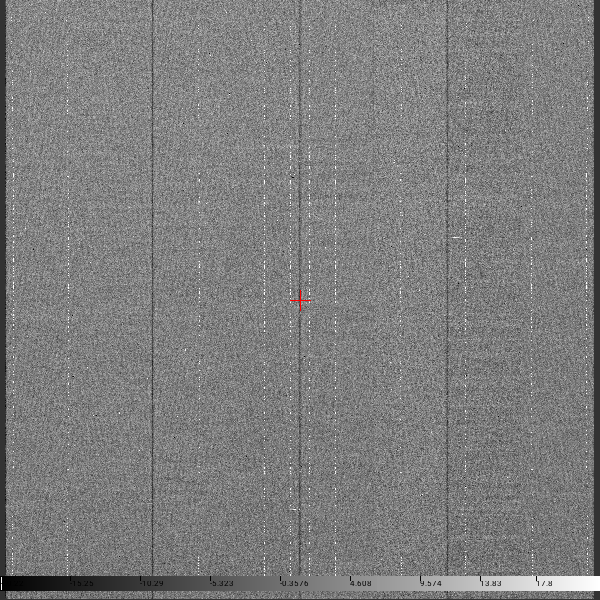

In [7]:
disp.get_viewer().show()

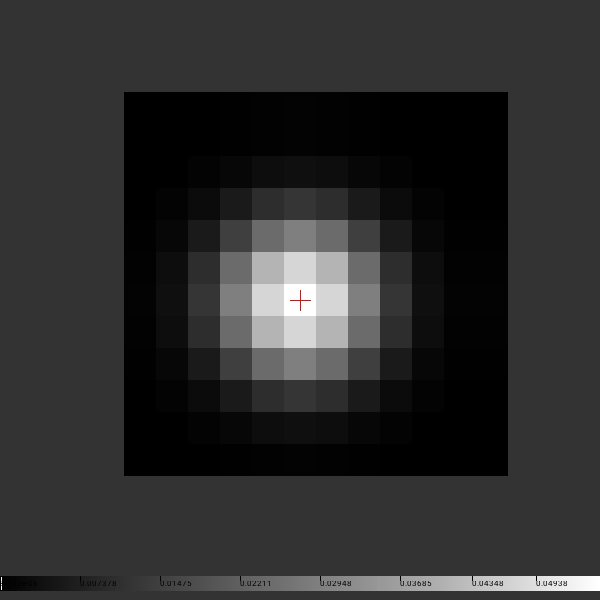

In [9]:
disp2.mtv(calexp.getPsf().computeImage())
disp2.zoom(32)
disp2.pan(0, 0)

disp2.get_viewer().show()

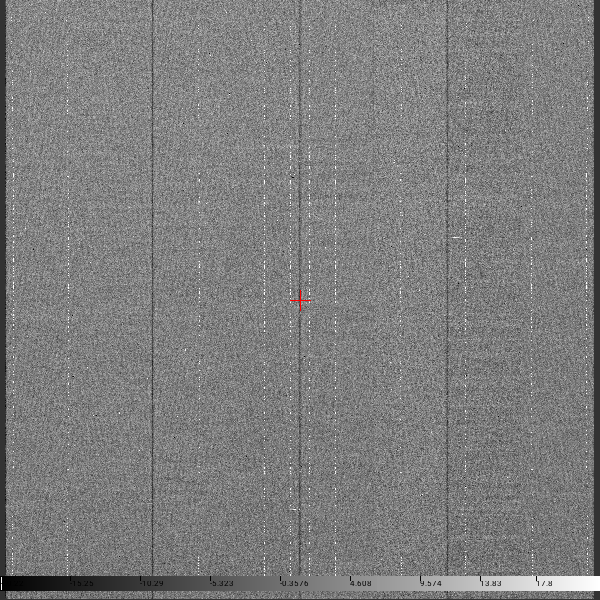

In [10]:
import lsst.meas.algorithms.utils as maUtils
reload(maUtils)
mos = maUtils.showPsfMosaic(calexp, nx=8, ny=8, showCenter=False, showFwhm=True, display=disp)
disp.scale('linear', 'minmax')
disp.get_viewer().show()

In [12]:
disp.pan(3197, 783)
disp.zoom(2)

Mask displays are not yet supported in Ginga


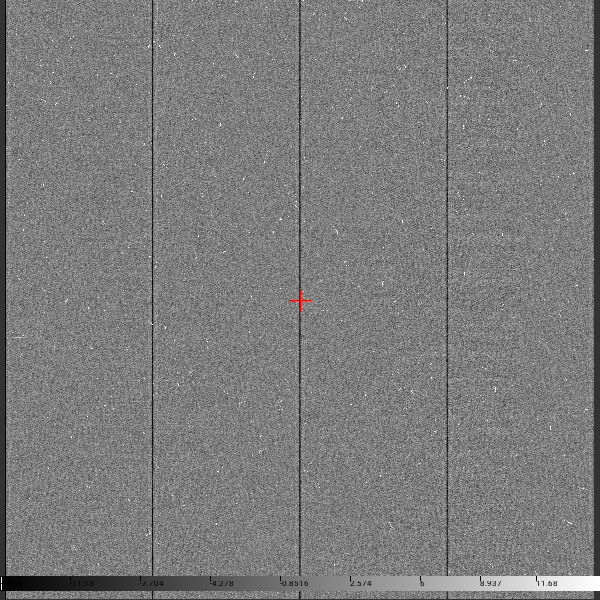

In [14]:
bias = butler.get("bias", dataId, arm="r")  # arm="m" fails
disp.mtv(bias, title="bias")
disp.scale('linear', 'zscale')
disp.get_viewer().show()

Mask displays are not yet supported in Ginga


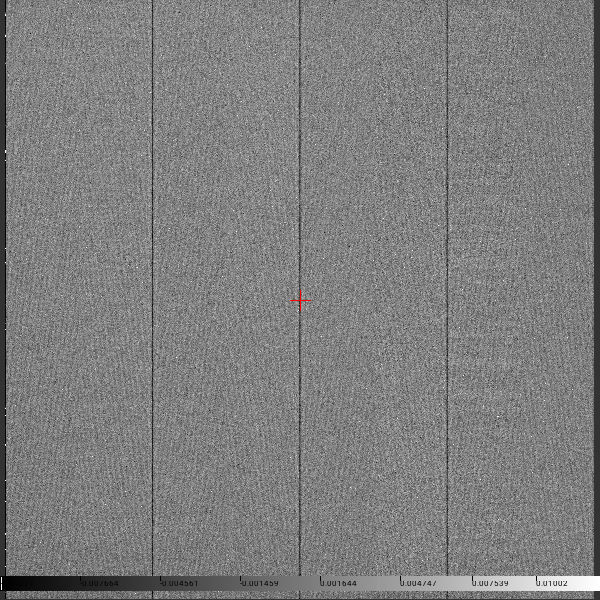

In [15]:
dark = butler.get("dark", dataId)
disp.mtv(dark, title="dark")
disp.get_viewer().show()

Mask displays are not yet supported in Ginga


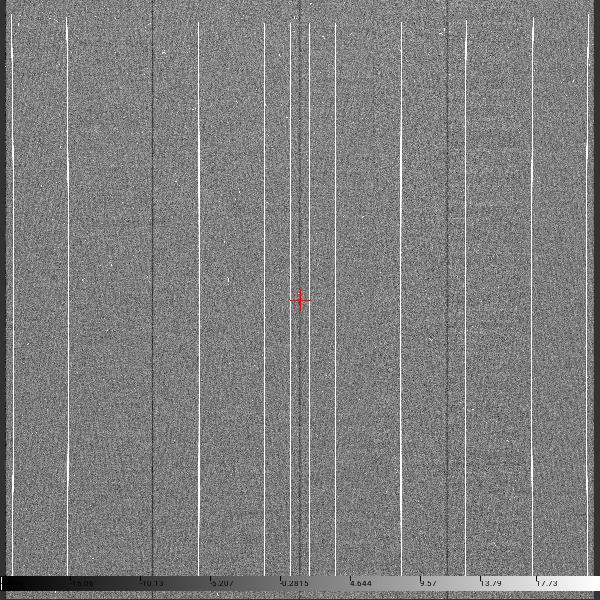

In [16]:
flat = butler.get("flat", dataId)
disp.mtv(flat, title="flat")
disp.get_viewer().show()

In [17]:
raw = butler.get("raw", dataId, visit=7253)
disp.mtv(raw, title="raw 7253")

raw2 = butler.get("raw", dataId, visit=7251)
disp2.mtv(raw2, title="raw 7251")
disp2.get_viewer().embed()

print "Exposure time: %.1fs" % (raw.getCalib().getExptime())

Mask displays are not yet supported in Ginga
Mask displays are not yet supported in Ginga
Exposure time: 0.0s


In [18]:
import lsst.afw.cameraGeom.utils as cgUtils

disp.mtv(raw, title='Raw dark 7291')
disp.scale('linear', 'zscale')

cgUtils.overlayCcdBoxes(raw.getDetector(), raw.getBBox(), nQuarter=0, isTrimmed=False,
                        ccdOrigin=afwGeom.PointI(0,0), display=disp, binSize=1)
disp.get_viewer().embed()

Mask displays are not yet supported in Ginga


In [19]:
visit = 7291 if True else 4
raw = butler.get("raw", dataId, visit=visit)
disp2.mtv(raw, title="dark" if visit == 7291 else "arc")

print "%.1fs" % (raw.getCalib().getExptime())

Mask displays are not yet supported in Ginga
1200.0s


### Note that the pfsArm files do not (yet!) conform to the datamodel

In [20]:
if False:
    spa = butler.get("spArm", dataId, immediate=True)

In [21]:
import pyfits

def readPfsArmAndreas(pfsArm, fileName):
    """Read non-datemodel compliant pfsArm files"""
    fd = pyfits.open(fileName)

    for hduNum, hduName in [(4, "WAVELENGTH"), (1, "FLUX"), 
                            (2, "COVAR"), (3, "MASK"), (5, "SKY")]:
        if hduName == "SKY":
            hduNum = 6        # bug in Andreas's code
        hdu = fd[hduNum]
        hdr, data = hdu.header, hdu.data.T
        #print hduName, hdu.data.shape
        
        if hduName == "COVAR" and data.ndim == 2:
            data = data.reshape(data.shape[0], 5, data.shape[1]//5)

        if False:
            for k, v in hdr.items():
                print "%8s %s" % (k, v)

        if data.ndim == 2:
            if hduName == "WAVELENGTH":
                pfsArm.lam = 0.1*data
            elif hduName == "FLUX":
                pfsArm.flux = data
            elif hduName == "MASK":
                pfsArm.mask = data
            elif hduName == "SKY":
                pfsArm.sky = data
            else:
                raise RuntimeError("Unexpected HDU %s reading %s" % (hduName, fileName))
        else:
            if hduName != "COVAR":
                raise RuntimeError("Unexpected HDU %s reading %s" % (hduName, fileName))

            pfsArm.covar = data

        #print hdr["EXTNAME"], hdr["XTENSION"], data.dtype, data.shape

    return

    hdu = fd[7]          # CONFIG; should be 6
    hdr, data = hdu.header, hdu.data

    assert 'pfsConfigId' in data.names
    assert 'visit' in data.names
    assert len(data['visit']) == 1   # only one row in the table

    if data['visit'][0] != self.visit:
        raise RuntimeError("Filename corresponds to visit %d, but config gives %d" %
                           self.visit, data['visit'][0])

    pfsArm.pfsConfigId = data['pfsConfigId'][0]

    if pfsConfigs is None:
        pfsConfigs = {}             # n.b. won't be passed back to caller

    if self.pfsConfigId not in pfsConfigs:
        pfsConfigs[self.pfsConfigId] = PfsConfig(self.pfsConfigId)
        pfsConfigs[self.pfsConfigId].read(dirName)

    pfsArm.pfsConfig = pfsConfigs[pfsArm.pfsConfigId]

    if len(pfsArm.flux) != len(pfsArm.pfsConfig.ra):
        raise RuntimeError("Mismatch between pfsArm and pfsConfig files")
    if True:
        print "%d%s 0x%x %d" % \
           (pfsArm.spectrograph, pfsArm.arm, pfsArm.pfsConfigId, pfsArm.visit),  \
            pfsConfig.ra, pfsConfig.dec

In [22]:
fn = butler.get("spArm_filename", dataId, immediate=True)[0]

pfsArm = PfsArm(spectrograph=dataId["spectrograph"], arm=dataId["arm"], visit=4)
readPfsArmAndreas(pfsArm, fn)

<IPython.core.display.Javascript object>


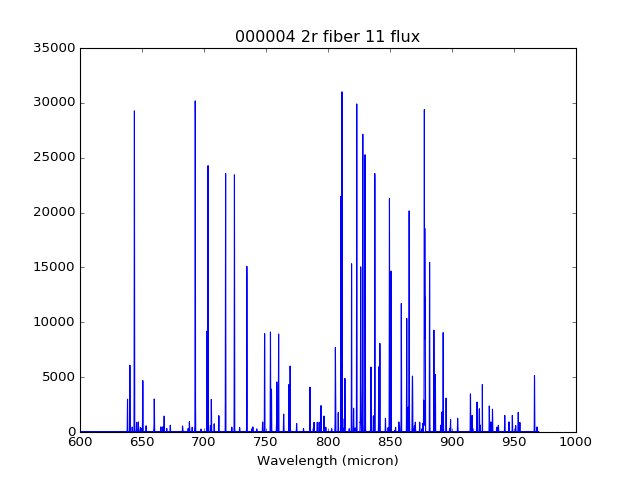

In [23]:
for fid in range(1, len(pfsArm.flux[:, 0]) + 1):
    if fid == 11:
        pfsArm.plot(fid, showFlux=True)
plt.xlim(600, 1000)
#plt.ylim(-10, 10000)
if figDir:
    plt.savefig(os.path.join(figDir, "arc-4-extracted.png"))
plt.show()

In [ ]:
for i in range(len(pfsArm.flux[:, 0])):
    plt.plot(pfsArm.lam[i], pfsArm.flux[i], label=str(i + 1))
plt.xlim(856 - 10, 858 + 10)
plt.xlabel(r"$\lambda (nm)$")
plt.ylim(-10, 5000)
plt.legend(loc='upper right')
if figDir:
    plt.savefig(figDir, "arc-4-extracted-detail.png")
plt.show()

In [24]:
butler.queryMetadata("raw", "visit")

[4, 5, 7251, 7252, 7253, 7291, 7292, 7293]

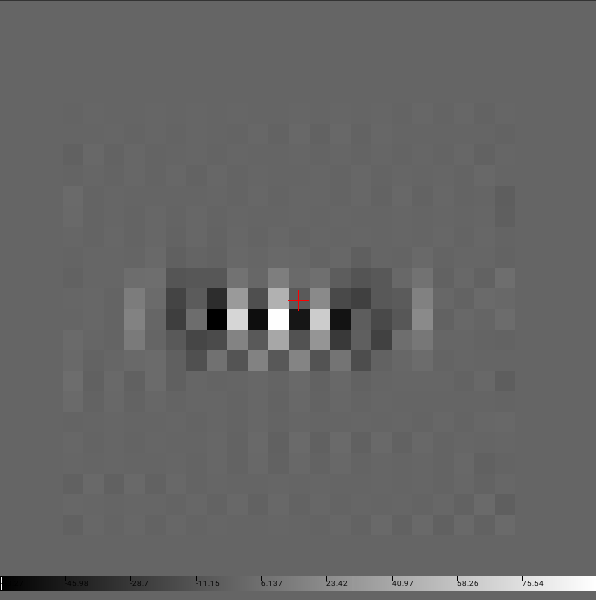

In [26]:
import lsst.afw.math as afwMath
import lsst.afw.display.utils as afwDisplayUtils
reload(afwDisplayUtils)

spot = exp[1967:1997, 2254:2284].getMaskedImage().getImage()
spot1 = afwMath.offsetImage(spot, 0.5, 0)
spot2 = afwMath.offsetImage(spot1, -0.5, 0)
spot2 -= spot
m = afwDisplayUtils.Mosaic()
#m.makeMosaic([spot, spot1, spot2]) # , display=disp)
disp.mtv(spot2)
disp.scale('linear', 'minmax')
disp.get_viewer().show()